# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from velocereduction import config
import velocereduction as VR

from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [2]:
starting_memory = VR.utils.get_memory_usage()
print('Memory before starting the reduction:')
print(starting_memory)

Memory before starting the reduction:
Run on Apple/Darwin: 617.7MB


## Adjust Date and Directory (possibly via argument parser)

In [3]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"

        # CV dates
        # jupyter_date = "250604"
        # jupyter_date = "250706"
        # jupyter_date = "250707"

        # Radio GAGA
        jupyter_date = "251102"

        jupyter_working_directory = "../"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date

if args.working_directory[:2] in ['./','~/']:
    config.working_directory = str(Path(args.working_directory).resolve())+'/'
else:
    config.working_directory = str(Path(args.working_directory).resolve())+'/'
print(f"Date: {config.date}, Working Directory: {config.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 251102, Working Directory: /Users/buder/velocereduction/


## Identfiy Calibration and Science Runs

In [4]:
# Extract the Calibration and Science data from the night log

each_science_run_separately = True # Set this True, if you want to reduce the runs of the same object separately

calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(
    config.date,
    config.working_directory+'observations/',
    each_science_run_separately = each_science_run_separately
)


  ||
  ||  --> Identifying calibration and science runs now
  ||
  ||  --> Found Log file /Users/buder/velocereduction/observations//251102/251102-AAT-2025A-25.log
  ||
  || DarkFrame observations: 0.1, 15.0, 60.0, 1800.0
  ||
  || Bstar observations happened at: 09:46:53, 13:45:20, 17:27:15
  ||
  || The following science observations were identified: HD209952_0109, 6621775659788740224_0118, 6621775659788740224_0119, 2423041401023478528_0125, 2423041401023478528_0126, 5023909390291262464_0129, 5023909390291262464_0130, HD14228_0133, 5023909390291262464_0140, 4666183282194763392_0143, 4641706710251316352_0147, 4666005951584859648_0150, 4654946101574042752_0153, 4655499396457318144_0156, HD47670_0159, 5598559212594993152_0166
  ||
  || Will save reduced data into directory /Users/buder/velocereduction/reduced_data/251102
  ||



## Extract orders and save in initial FITS files with an extension per order.

In [ ]:
# Extract Master Flat
print('\nExtracting Master Flat')
master_flat, master_flat_images = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['Flat_60.0'],
    ccd2_runs = calibration_runs['Flat_1.0'],
    ccd3_runs = calibration_runs['Flat_0.1'],
    Flat = True,
    update_tramlines_based_on_flat = True, # Would update and overwrite
    # ./VeloceReduction/tramline_information/tramline_begin_end_ccd_*_oder_*.txt
    debug_overscan = False,
    debug_rows = False, # Plotting the distribution of counts of a tramline in every 500th row
    debug_tramlines = True # Would create a tramlines trace PDF under
    # reduced_data/YYMMDD/debug/debug_tramlines_flat.pdf
)

# Extract Master ThXe
print('\nExtracting Master ThXe')
master_thxe = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['FibTh_180.0'],
    ccd2_runs = calibration_runs['FibTh_60.0'],
    ccd3_runs = calibration_runs['FibTh_15.0'],
    ThXe = True,
    master_flat_images = master_flat_images,
    debug_tramlines = True # Would create a tramlines trace PDF under
    # reduced_data/YYMMDD/debug/debug_tramlines_thxe.pdf
)

# Extract Master LC
if len(calibration_runs['SimLC']) > 0:
    print('\nExtracting Master LC')
    master_lc = VR.extraction.extract_orders(
        ccd1_runs = calibration_runs['SimLC'],
        ccd2_runs = calibration_runs['SimLC'],
        ccd3_runs = calibration_runs['SimLC'],
        LC = True,
        master_flat_images = master_flat_images,
        debug_tramlines = True # Would create a tramlines trace PDF under
        # reduced_data/YYMMDD/debug/debug_tramlines_lc.pdf
    )
else:
    print('\nNo SimLC observed for this night; Skipping Master LC calibration and setting all values 1.0')
    master_lc = master_thxe.copy(); master_lc[:] = 1.0

# Extract Darks
master_darks = dict()
if len(calibration_runs['Darks']) > 0:
    print('\nExtracting Darks')
    for dark_exposure in calibration_runs['Darks'].keys():
        print('  --> '+str(dark_exposure)+': '+','.join(calibration_runs['Darks'][dark_exposure]))
        master_darks[dark_exposure] = VR.extraction.get_master_dark(calibration_runs['Darks'][dark_exposure])
else:
    print('\nNo Dark exposure found for '+config.date+'. Using Archvial exposure from 001122 (2Amp.)')
    master_darks['1800.0'] = VR.extraction.get_master_dark(calibration_runs['Darks'], archival=True)

# Extract BStars -> Telluric lines
master_bstars = dict()
if len(calibration_runs['Bstar']) > 0:
    print('\nExtracting Bstar-Tellurics')
    for bstar_exposure in calibration_runs['Bstar'].keys():
        print('  --> '+str(bstar_exposure)+': '+', '.join(calibration_runs['Bstar'][bstar_exposure]))
        telluric_flux, telluric_mjd = VR.extraction.get_tellurics_from_bstar(
            calibration_runs['Bstar'][bstar_exposure], master_flat_images,
            debug = False
        )
        master_bstars[telluric_mjd] = telluric_flux

In [ ]:
# Extract Science Objects and save them into FITS files under reduced_data/
for science_object in list(science_runs.keys()):
    print('\nExtracting '+science_object)

#     try:
    science, science_noise, science_header = VR.extraction.extract_orders(
        ccd1_runs = science_runs[science_object],
        ccd2_runs = science_runs[science_object],
        ccd3_runs = science_runs[science_object],
        Science=True,
        master_darks = master_darks, # These are needed to subtract the dark current
        master_flat_images = master_flat_images, # These are needed for flat-field correction
        debug_tramlines = True, # Would create a tramlines trace PDF under
        # reduced_data/YYMMDD/debug/debug_tramlines_{metadata['OBJECT']}.pdf
        debug_overscan=False
    )

    # Find the closest BStar calibration
    if len(master_bstars) > 0:
        mjd_science = science_header['UTMJD']
        mjd_tellurics = np.array(list(master_bstars.keys()))
        closest_tellurics = mjd_tellurics[np.argmin(np.abs(mjd_tellurics - mjd_science))]
        print(f'  --> Using telluric from B Star as observed at UTMJD {closest_tellurics} (Science taken at UTMJD {mjd_science})')
        telluric = master_bstars[closest_tellurics]
    else:
        print('No tellurics from B Stars available.')
        telluric = np.ones(np.shape(science))

    # Create a primary HDU and HDU list
    primary_hdu = fits.PrimaryHDU()
    header = primary_hdu.header
    header['OBJECT']             = (science_object,           'Name of observed object in night log')
    header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
    header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
    header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
    header['BARYVEL']            = (0.0,                      'Applied barycentric velocity correction')
    header['VRAD']               = ('None',                   'Radial velocity estimate')
    header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')

    # Use astroquery to update header with Simbad information (where available)
    # We try to find matches with HIP/2MASS/Gaia DR3 as well as
    # radial velocities (VRAD), stellar parameters (TEFF/LOGG/FE_H), and 
    # magnitudes in B/V/G/R as well as parallax PLX
    header = VR.utils.update_fits_header_via_crossmatch_with_simbad(header)

    hdul = fits.HDUList([primary_hdu])

    # Extract order ranges and coefficients
    order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

    # Loop over your extension names and corresponding data arrays
    for ext_index, ext_name in enumerate(order_beginning_coeffs):
        # Create an ImageHDU object for each extension

        # Define the columns with appropriate formats
        col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
        col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
        col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
        col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
        col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
        col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:])
        col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:])
        col8_def = fits.Column(name='telluric',format='E', array=telluric[ext_index,:])

        # Combine columns to BinTable and add header from primary
        hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def, col8_def], name=ext_name.lower())

        # Append the HDU to the HDU list
        hdul.append(hdu)

    # Save to a new FITS file with an extension for each order
    Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
    spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
    hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

    print('\n  --> Successfully extracted '+science_object)

#     except:
#         print('\n  --> Failed to extract '+science_object)

## Wavelength calibration

4641706710251316352_0147
  --> Optimising wavelength solution with LC peaks for ccd_3_order_93


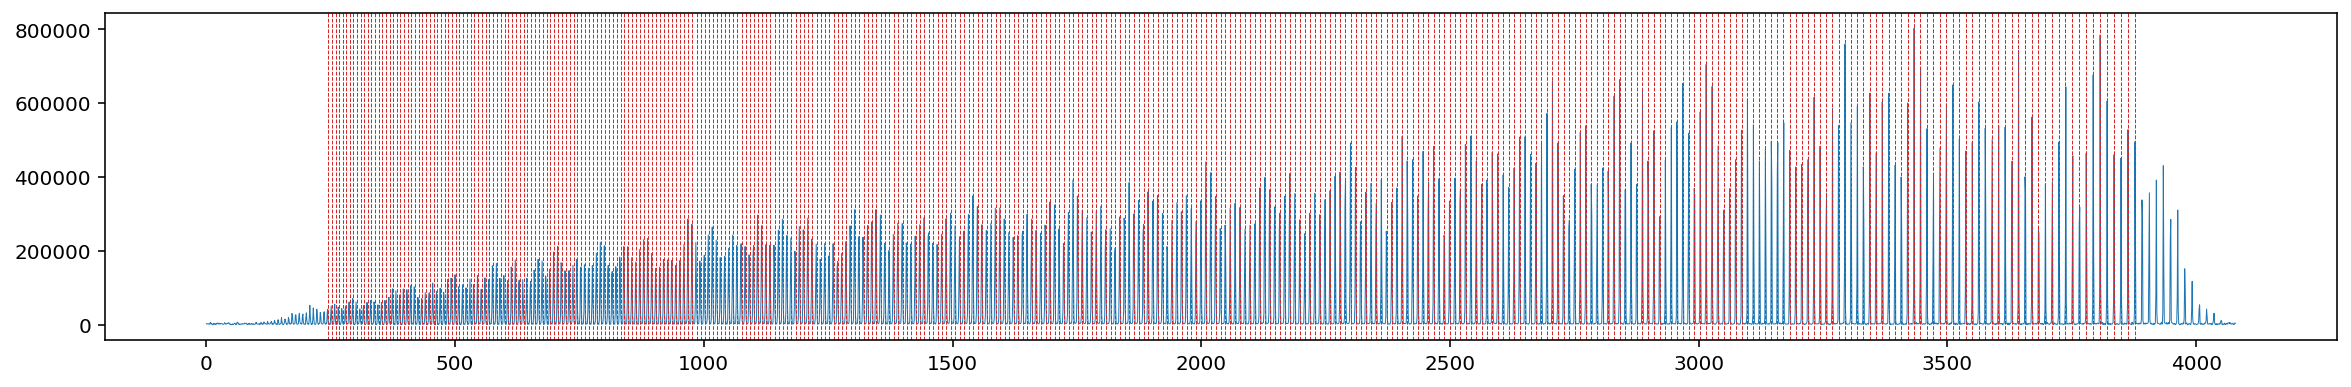

    --> Refitting wavelength solution after clipping 3 3-sigma RMS velocity outliers:  [ 244.  309. 2320.]


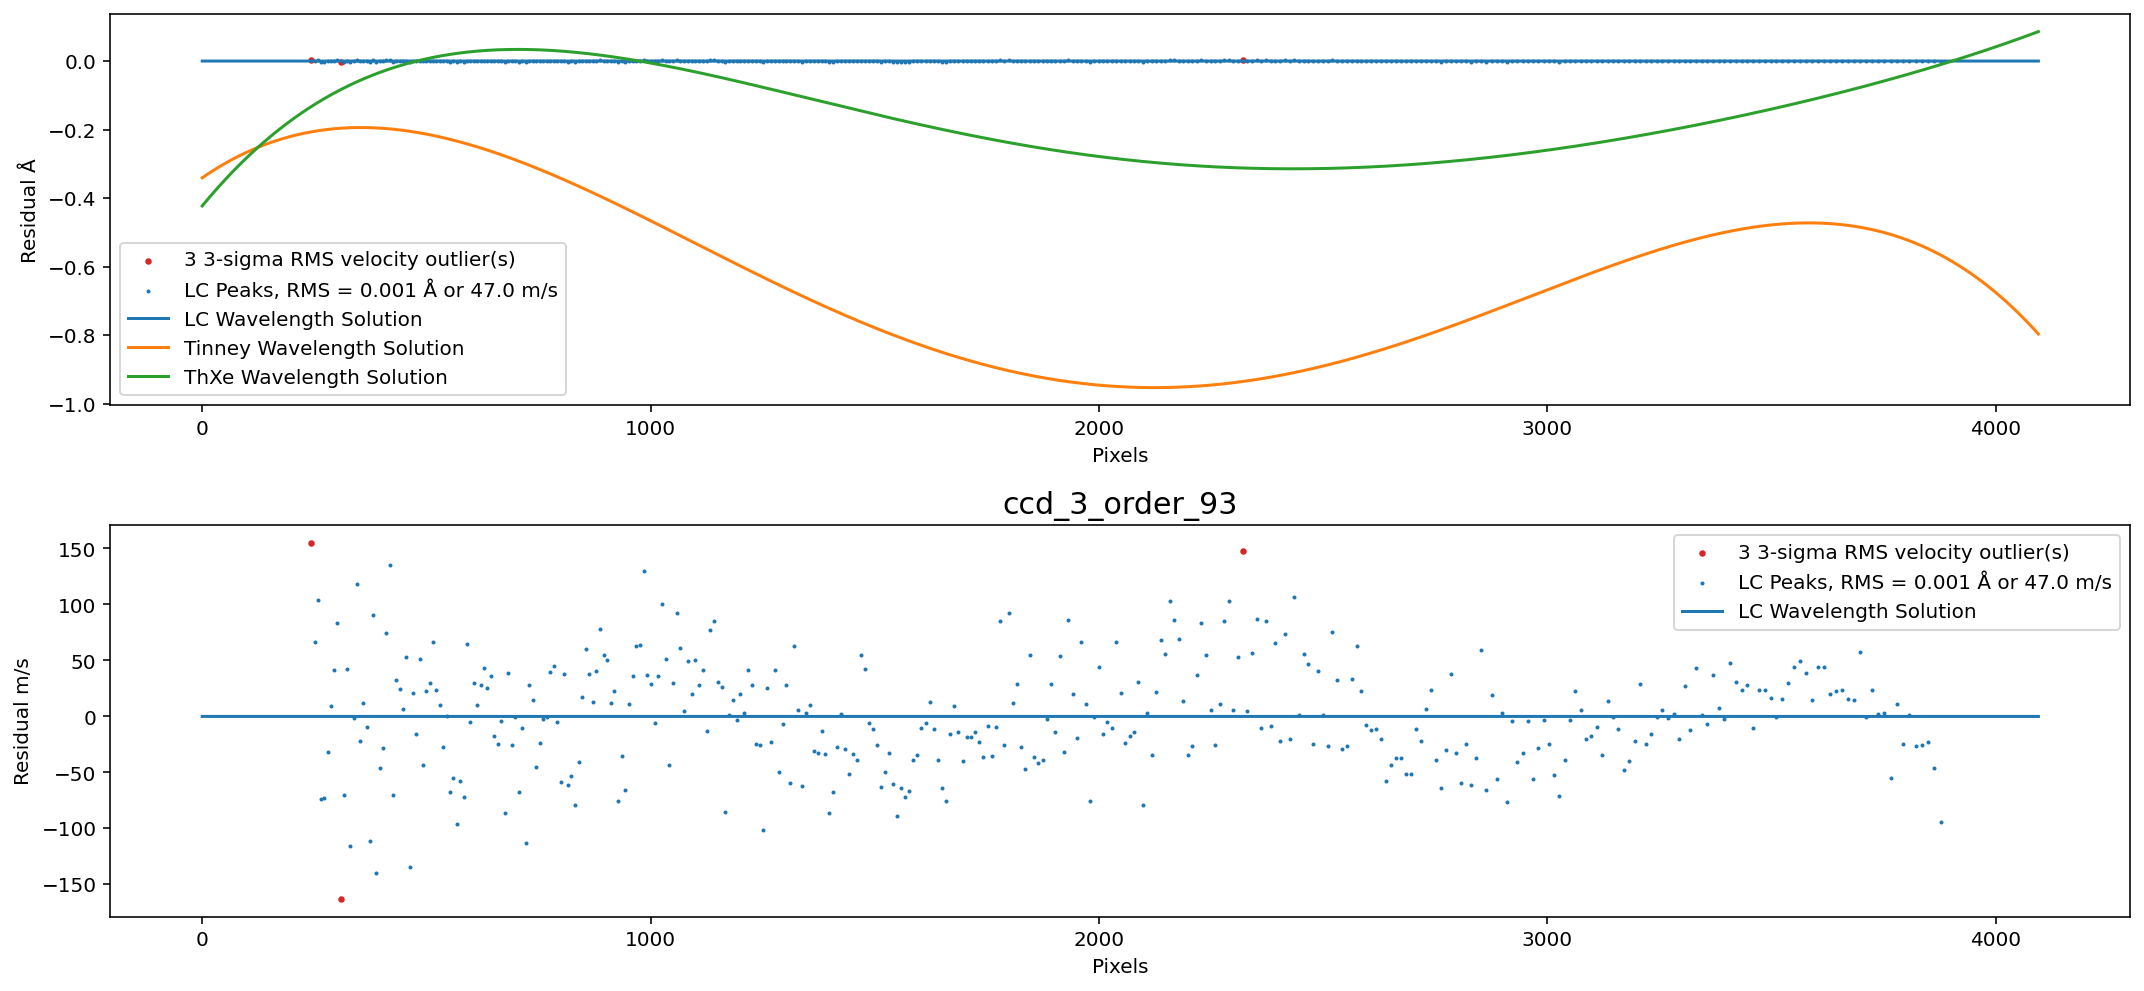

  --> Optimising wavelength solution with LC peaks for ccd_3_order_94


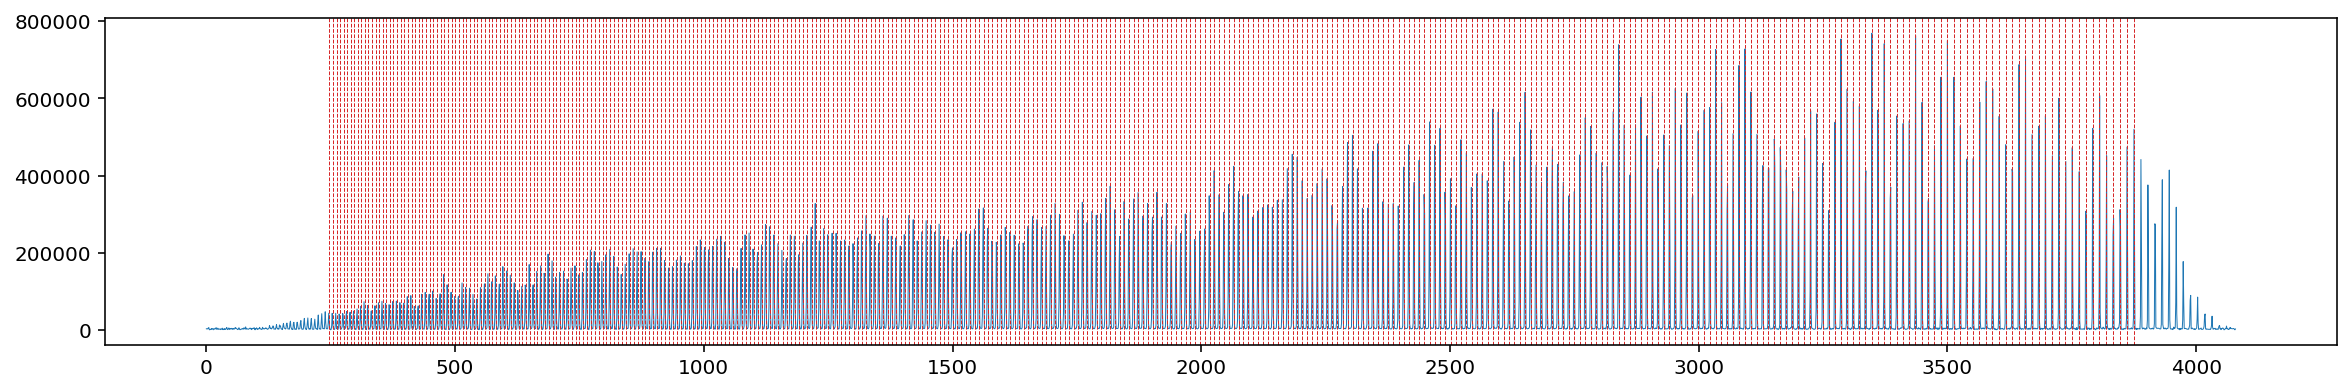

    --> Refitting wavelength solution after clipping 2 3-sigma RMS velocity outliers:  [ 303. 2084.]


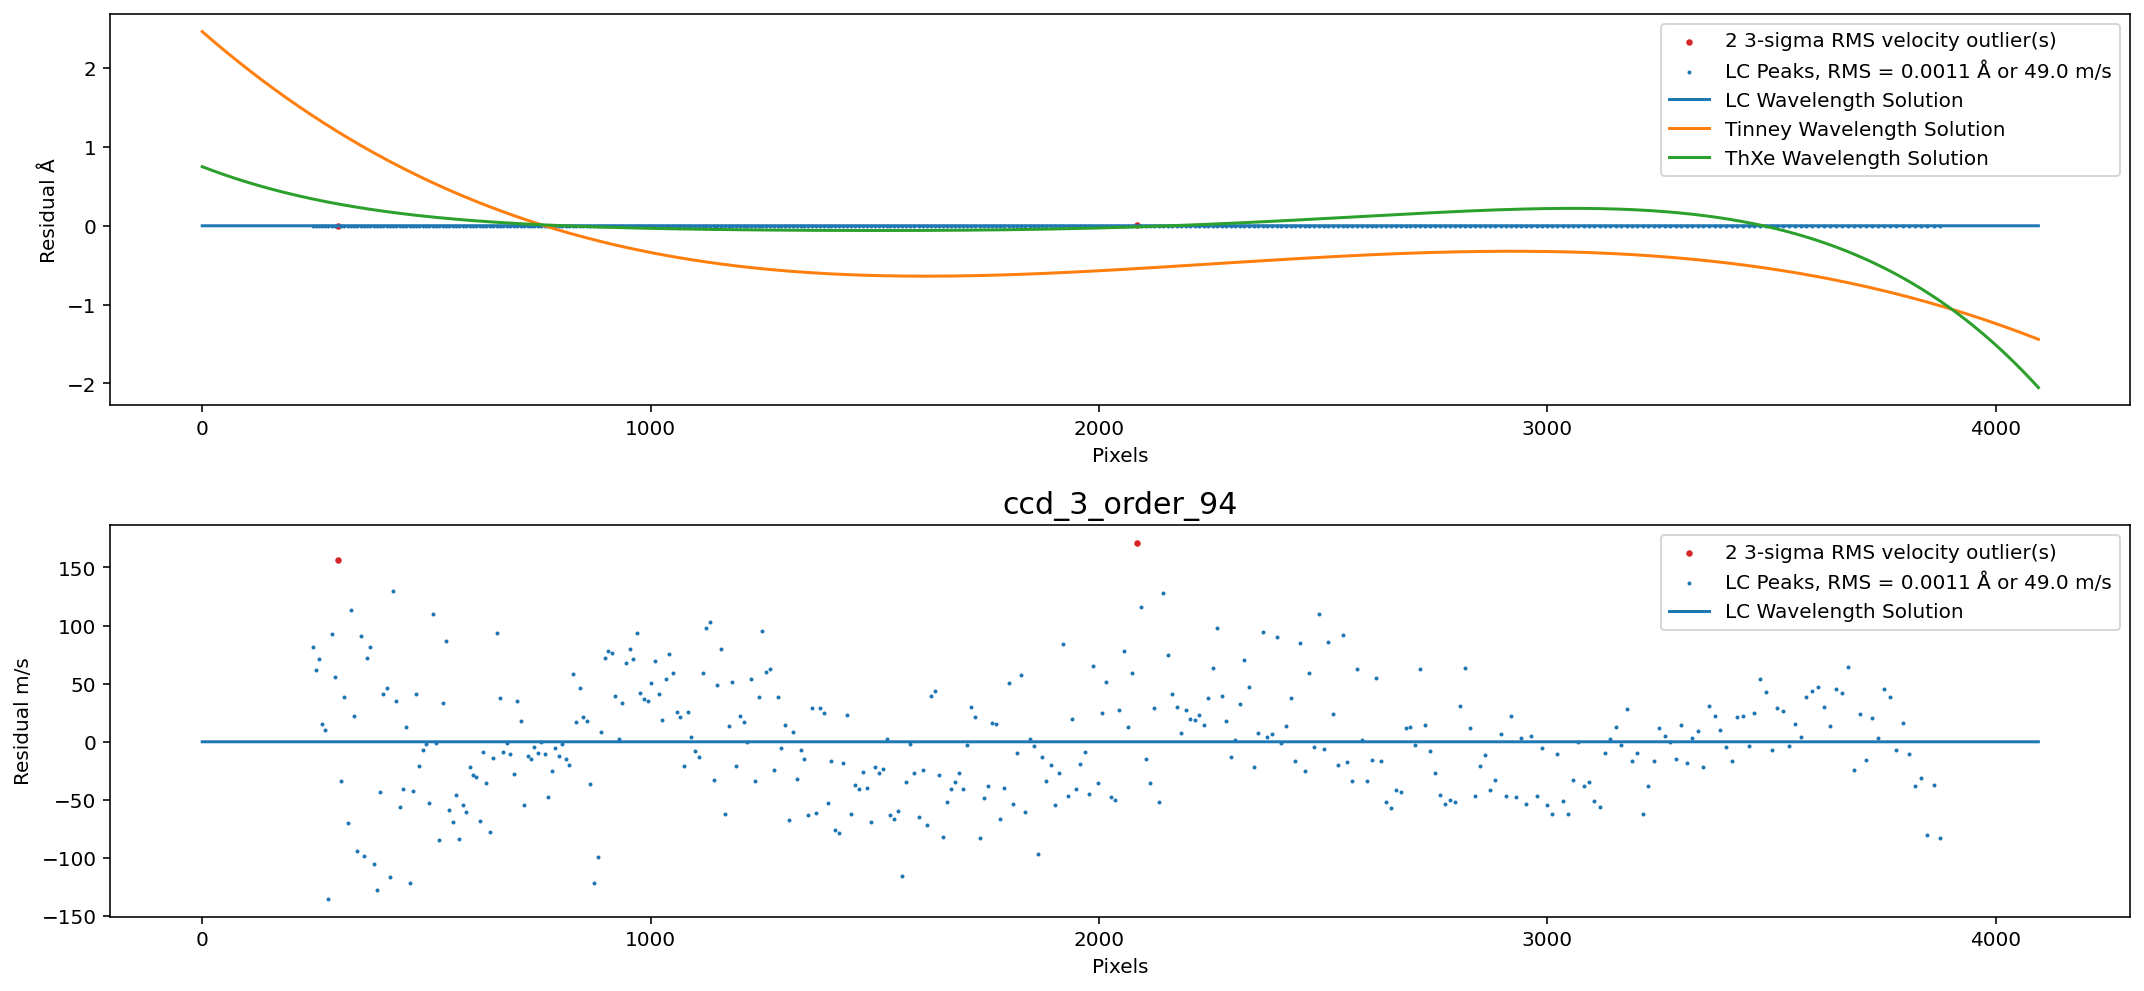

  --> Optimising wavelength solution with LC peaks for ccd_3_order_95


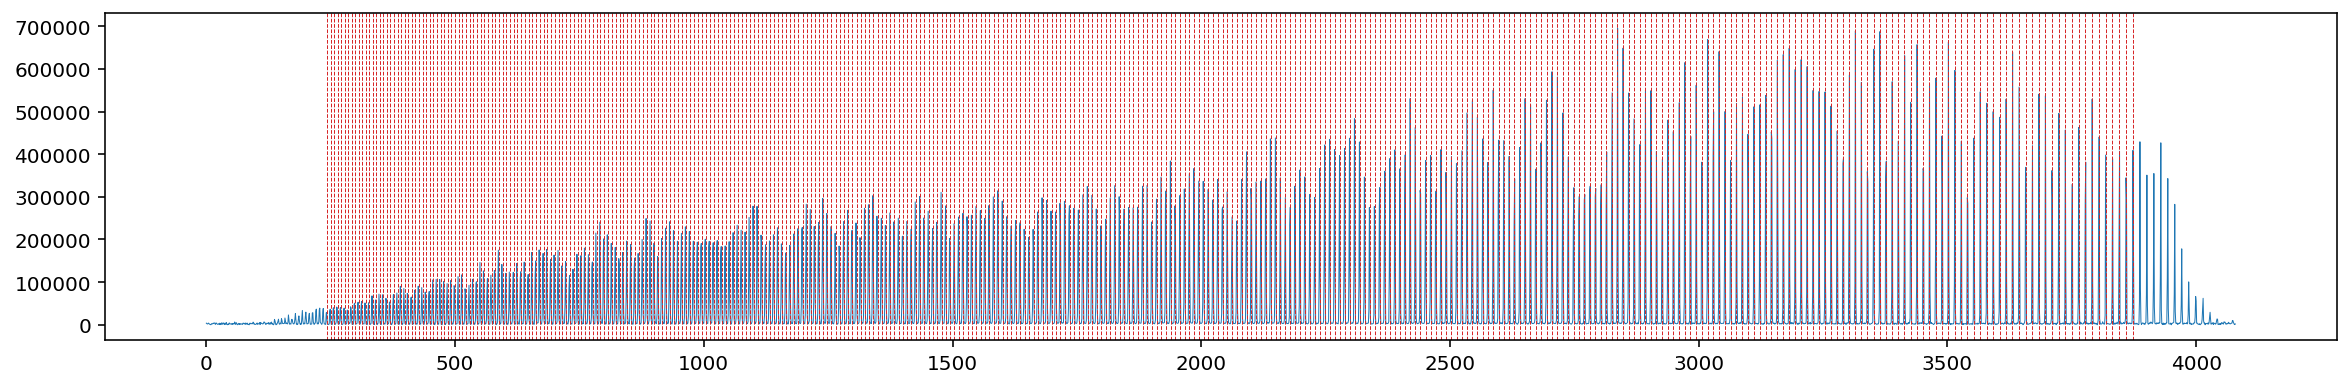

    --> Refitting wavelength solution after clipping 3 3-sigma RMS velocity outliers:  [290. 312. 354.]


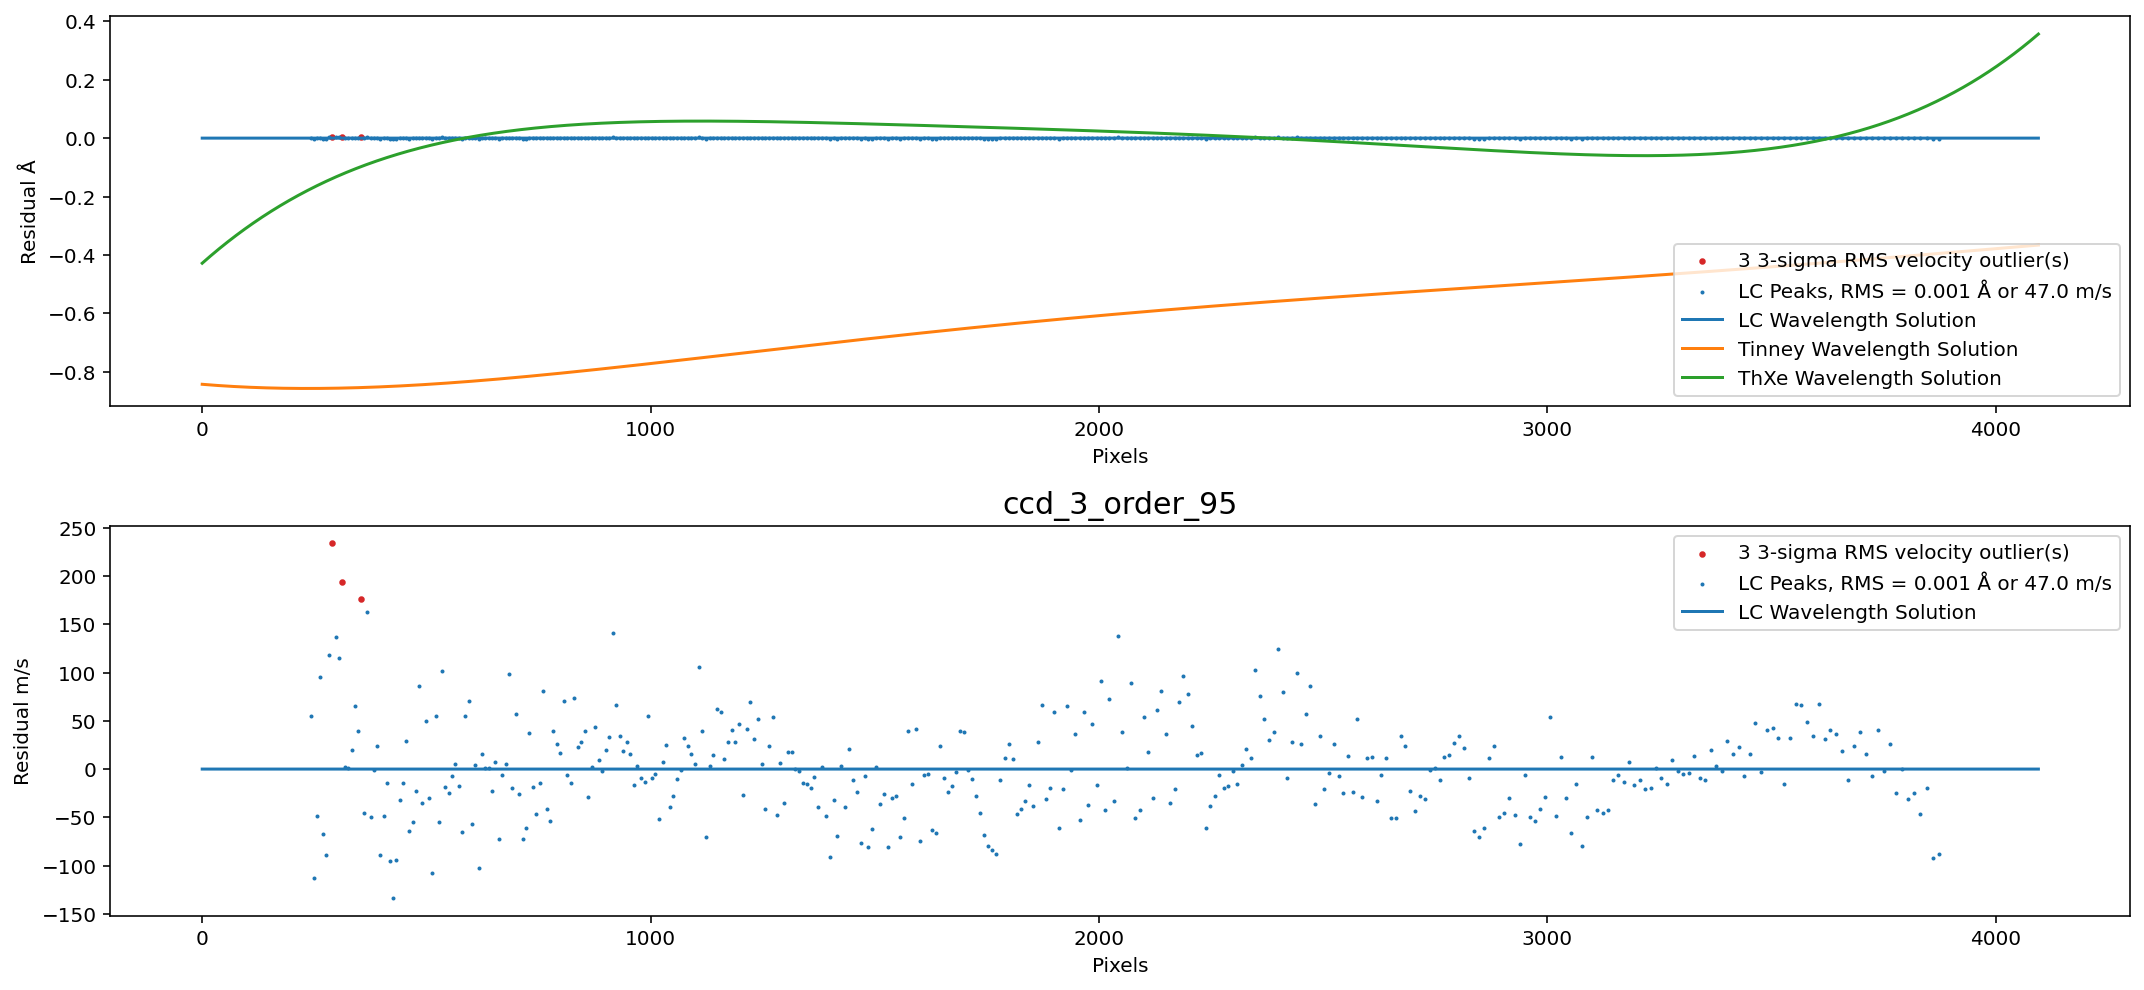

  --> Optimising wavelength solution with LC peaks for ccd_3_order_96


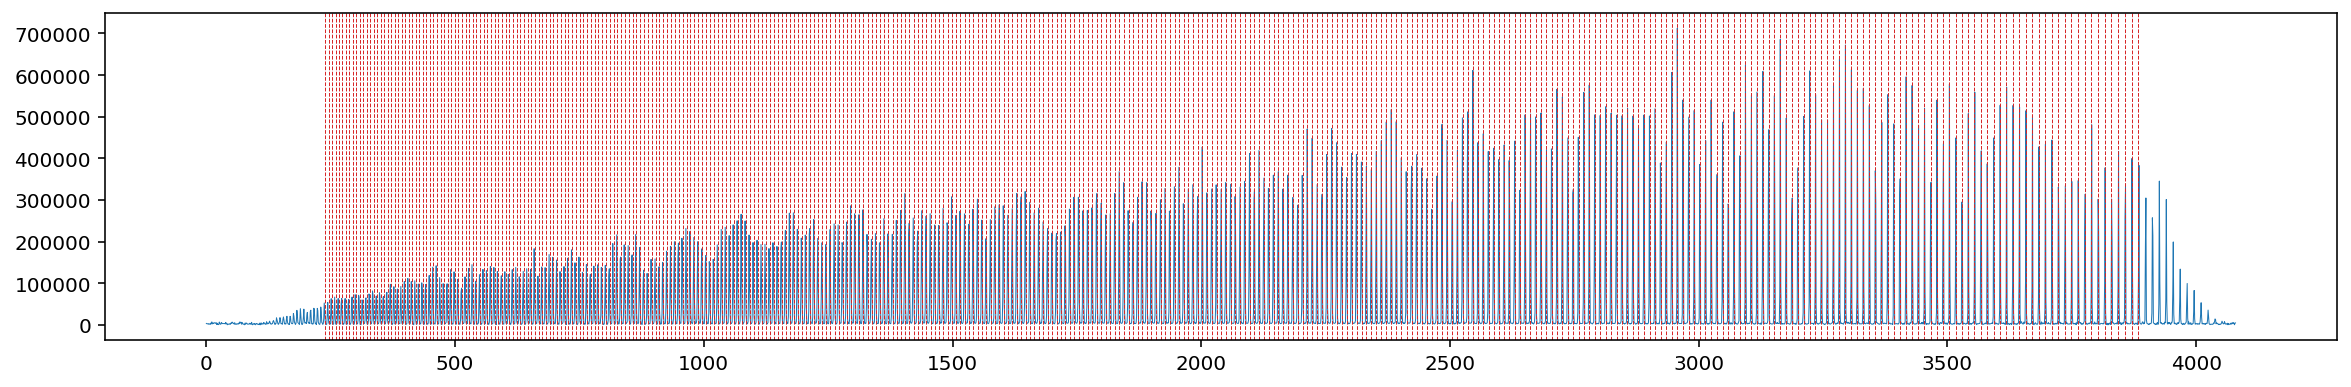

    --> Refitting wavelength solution after clipping 4 3-sigma RMS velocity outliers:  [244. 258. 279. 513.]


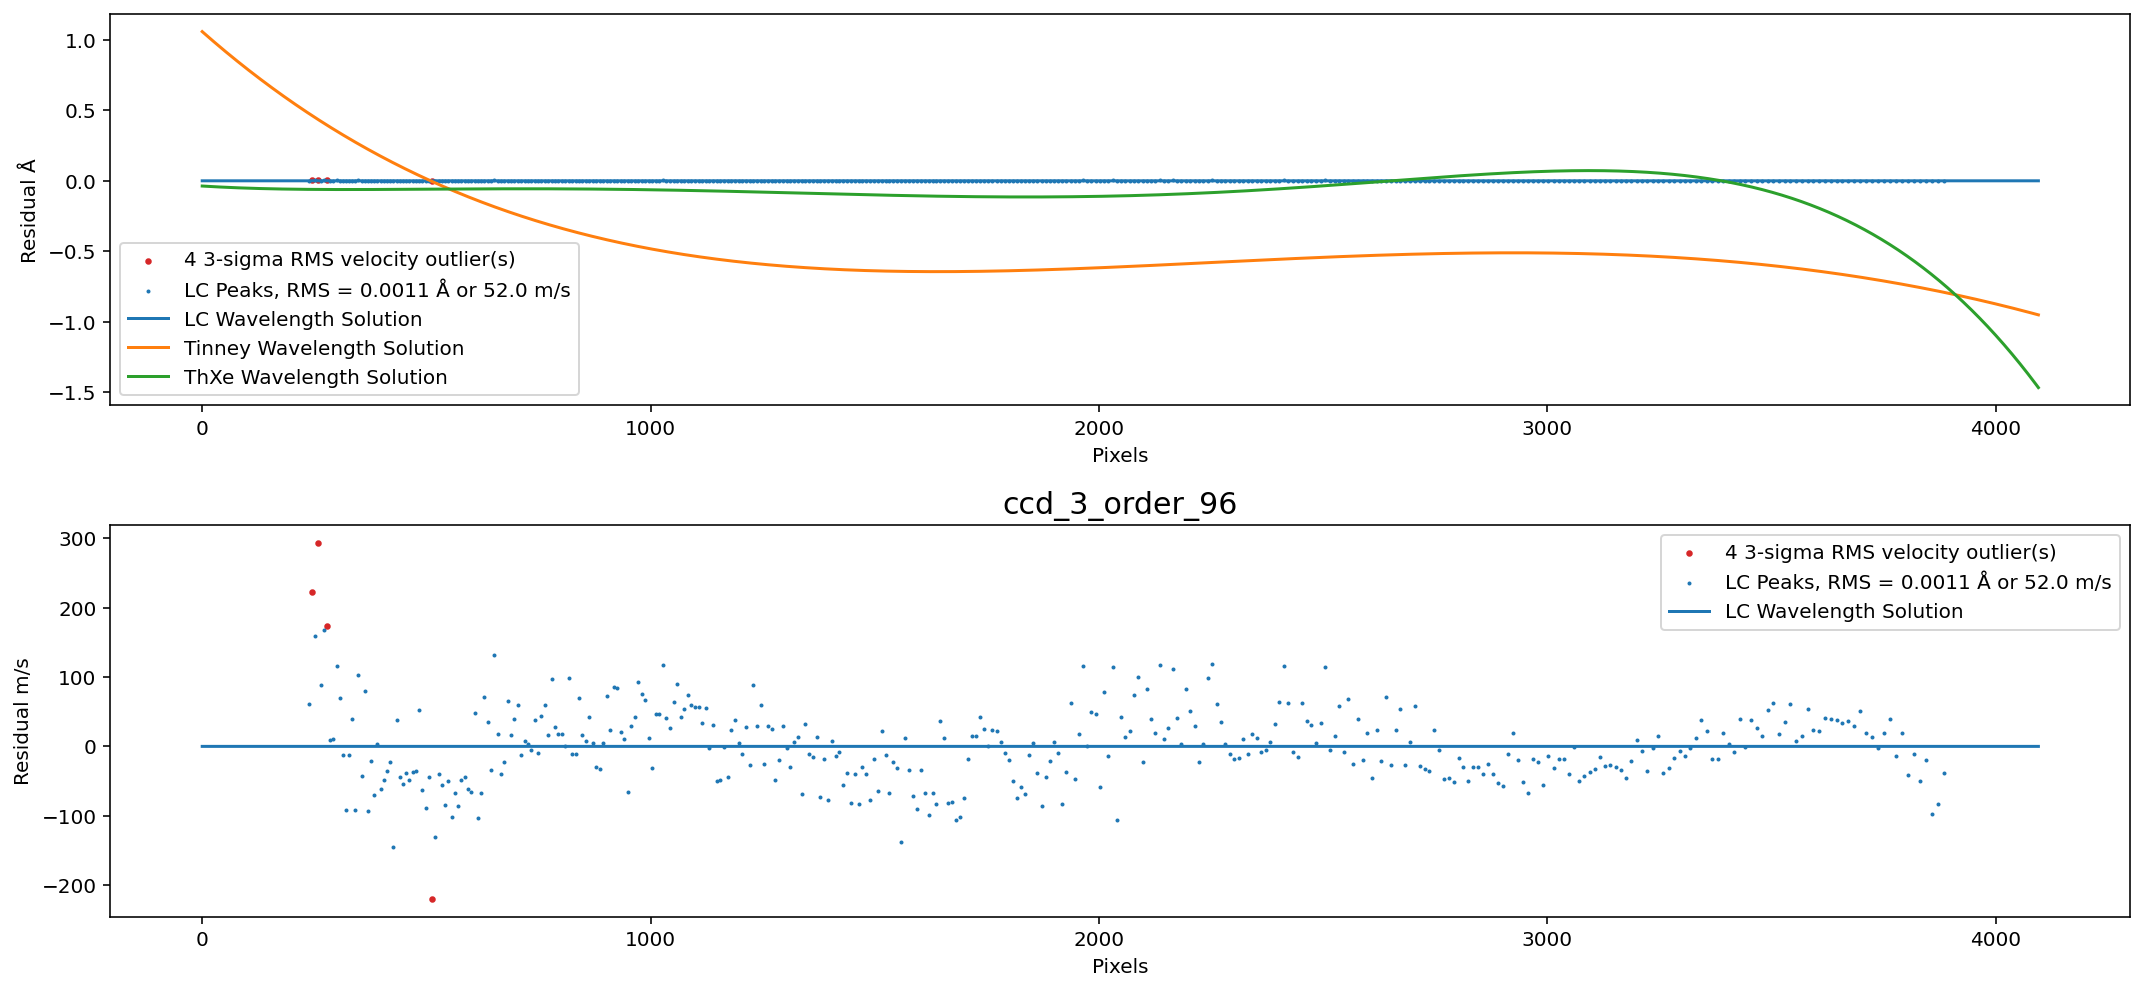

In [6]:
for science_object in list(science_runs.keys())[10:11]:

    print(science_object)

    file = fits.open('../reduced_data/'+config.date+'/'+science_object+'/veloce_spectra_'+science_object+'_'+config.date+'.fits')

    # VR.calibration.calibrate_wavelength(science_object, optimise_lc_solution = True, fit_voigt_for_rv = False, debug = True)

    # for order_index in range(1,len(file)):
    #     try:
    #         print(file[order_index].header['EXTNAME'], 'LC', file[order_index].header['WAVE_COEFF_LC_0'])
    #     except:
    #         try:
    #             print(file[order_index].header['EXTNAME'], 'ThXe', file[order_index].header['WAVE_COEFF_ThXe_0'])
    #         except:
    #             pass

    orders = ['ccd_3_order_93','ccd_3_order_94','ccd_3_order_95','ccd_3_order_96']

    for order in orders:

        # VR.calibration.calibrate_single_order(
        #     file,
        #     order
        # )

        coeffs_lc = VR.calibration.optimise_wavelength_solution_with_laser_comb(
            order_name = order,
            lc_pixel_values = file[order].data['LC'],
            debug = True
        )

In [ ]:
for science_object in list(science_runs.keys()):
#     try:
    VR.calibration.calibrate_wavelength(
        science_object,
        optimise_lc_solution=False,
        correct_barycentric_velocity=True,
        create_overview_pdf=True,
        fit_voigt_for_rv = False
    )
#         print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object+'\n')
#     except:
#         print('  -> Failed to calibrate wavelength for '+science_object+'\n')

## Comparison with synthetic spectra

In [ ]:
# for science_object in list(science_runs.keys()):
    
#     print('\nCalibrating wavelength for '+science_object+' with given radial velocity and synthetic Korg spectrum')
    
#     with fits.open(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/veloce_spectra_'+science_object+'_'+config.date+'.fits', mode='update') as veloce_fits_file:
        
#         korg_spectra = VR.flux_comparison.read_available_korg_syntheses()
        
#         # Find the closest match based on (possibly available) literature TEFF/LOGG/FE_H
#         closest_korg_spectrum = VR.flux_comparison.find_closest_korg_spectrum(
#             available_korg_spectra = korg_spectra,
#             fits_header = veloce_fits_file[0].header,
#         )

#         # Find the best RV or raise ValueError of none available.
#         vrad_for_calibration = VR.utils.find_best_radial_velocity_from_fits_header(fits_header = veloce_fits_file[0].header)

#         # Let's test this for a few orders (or simply set order_selection = None to use all valid ones)
#         orders_to_calibrate = ['ccd_3_order_94','ccd_3_order_89']

#         VR.flux_comparison.calculate_wavelength_coefficients_with_korg_synthesis(
#             veloce_fits_file,
#             korg_wavelength_vac = korg_spectra['wavelength_vac'],
#             korg_flux = korg_spectra['flux_'+closest_korg_spectrum],
#             vrad_for_calibration = vrad_for_calibration,
#             order_selection=orders_to_calibrate,
#             telluric_hinkle_or_bstar = 'hinkle', # You can choose between 'hinkle' and 'bstar'
#             debug=False
#         )

## Monitor RV (for stars with multiple observations and seperate reductions)

In [ ]:
repeated_observations = VR.utils.check_repeated_observations(science_runs)

VR.utils.monitor_vrad_for_repeat_observations(config.date, repeated_observations)

## Final Memory Check

In [ ]:
print('Memory before starting the reduction was:')
print(starting_memory)
print('Memory after running the reduction is:')
print(VR.utils.get_memory_usage())